In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re
import pickle

from Plot_events_functions import *

In [136]:
def find_part_with_most_rain(array, n, plot=False):
    # Compute differences
    # Split the array into 5 equal parts
    splits = np.array_split(array, n)
    
    max_array_rainfall = 0
    max_array_num = None
    
    # Find the fifth with the most rainfall
    for i, split in enumerate(splits, 1):
        if split.sum() > max_array_rainfall:
            max_array_num = i
            max_array_rainfall = split.sum()
            
    if plot ==True:
        # Plot the array
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(array) + 1), array, label='Precipitation', marker='o')

        # Add dotted lines to show the fifths
#         for i in range(0, 6):
#             plt.axvline(x=len(array) * i / 5, color='r', linestyle='--', label=f'Fifth {i}')

        # Shade the fifth with the most rainfall
        split_indices = np.linspace(0, len(array), 6, dtype=int)
        start_index = split_indices[max_array_num - 1] 
        end_index = split_indices[max_array_num] + 1
        plt.fill_between(range(start_index, end_index), array[start_index-1:end_index-1], color='yellow', alpha=0.3, label=f'Fifth {max_array_num} with most rain')

        plt.title('Precipitation Values with Fifths Marked')
        plt.xlabel('Time')
        plt.ylabel('Precipitation')
        plt.legend()
        plt.show()

    return max_array_num

In [144]:
nimrod_option = "NIMROD_1km_filtered_300"
pickle_fp_basedir = f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD_5mins/WholeYear/"
pickle_fp_profiles = pickle_fp_basedir + f"{nimrod_option}_{'good_normalised_interpolated_events'}.pkl"
pickle_fp_max_quintiles = pickle_fp_basedir + f"{nimrod_option}_{'good_normalised_interpolated_events_max_quintiles'}.pkl"
pickle_fp_trimmed_events = pickle_fp_basedir + f"{nimrod_option}_{'good_trimmed_events'}.pkl"
pickle_fp_durations = pickle_fp_basedir + f"{nimrod_option}_{'good_trimmed_events_durations'}.pkl"

###########################    
with open(pickle_fp_profiles, 'rb') as f:
    profiles = pickle.load(f)
with open(pickle_fp_max_quintiles, 'rb') as f:
    max_quintiles = pickle.load(f)
with open(pickle_fp_trimmed_events, 'rb') as f:
    trimmed_events = pickle.load(f)
with open(pickle_fp_durations, 'rb') as f:
    durations = pickle.load(f)    

## Classify and plot dimensionless profiles
### All profiles

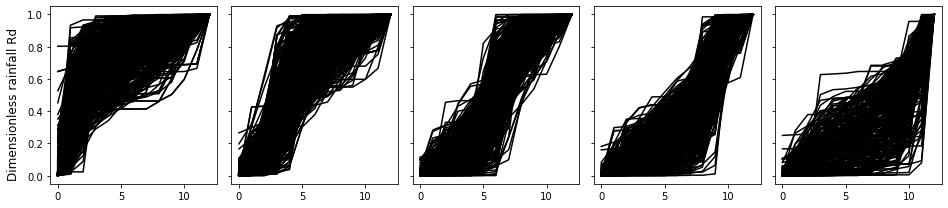

In [145]:
# Prepare the subplots
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(13, 3), sharey=True)

# Example profiles (using random synthetic data for demonstration)
np.random.seed(0)  # For reproducibility

# Loop through a subset of profiles
for num in range(0,len(profiles)):  # Adjust indices as needed
    if len(trimmed_events[num]['precipitation (mm)']) >5:
        heaviest_segment = find_part_with_most_rain(trimmed_events[num]['precipitation (mm)'], 5)
        # heaviest_segment=max_quintiles[num]
        profile = profiles[num]
        # Plot on the appropriate subplot based on the heaviest segment
        axs[heaviest_segment-1].plot(profile, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
                                  color='black')

# Adjust the layout
fig.tight_layout()
fig.supylabel('Dimensionless rainfall Rd', x=- 0.01)
plt.show()

### Split by duration bins

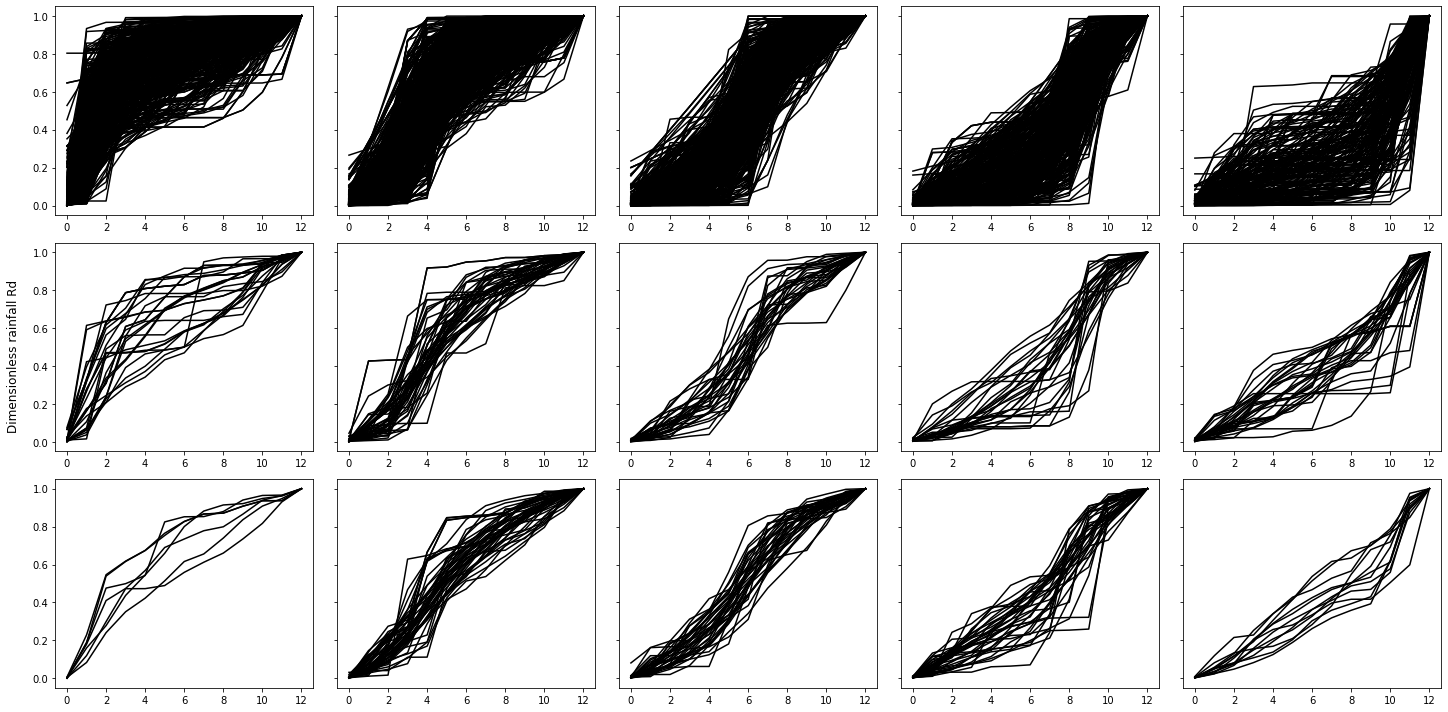

In [149]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20, 10), sharey=True)

# Example profiles (using random synthetic data for demonstration)
np.random.seed(0)  # For reproducibility

# Loop through a subset of profiles
for num in range(0,len(profiles)):  # Adjust indices as needed
    heaviest_segment = find_part_with_most_rain(trimmed_events[num]['precipitation (mm)'], 5)
    profile = profiles[num]
    duration =durations[num]
    
    if duration < 6:
        axs[0,heaviest_segment-1].plot(profile, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
                                  color = 'black')
    elif duration >=6 and duration <8:
        axs[1,heaviest_segment-1].plot(profile, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
                                  color = 'black')
    else:
        axs[2,heaviest_segment-1].plot(profile, label=f'Profile with heaviest in segment {heaviest_segment + 1}',
                                  color = 'black')   

# Adjust the layout
fig.tight_layout()
fig.supylabel('Dimensionless rainfall Rd', x=- 0.01)
plt.show()

# Generate summary profiles
Run cluster analysis on the profiles to identify clusters of events with similar profiles.  
This is performed on the cumulative, normalised rainfall profiles.  
The objective is to group similar rainfall events based on how rainfall accumulates over time (regardless of individual intensities or durations).  
The output of this is centroids which represent the average cumulative profile of each cluster.   

### Assign each profile to one of N clusters

In [155]:
# Assuming `profiles` is your array where rows are the dimensionless profiles
num_clusters = 5  # number of clusters

# Create and fit the model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(profiles)

# Get cluster labels for each profile
labels = kmeans.labels_

In [82]:
# df= pd.DataFrame({'cluster_num':labels, 'duration':durations_for_profiles})
# df['duration'] =  pd.to_numeric(df['duration'])
# df.groupby('cluster_num')['duration'].mean()

### Find the mean of each set of profiles - the 'summary profiles'

In [156]:
# Extract the centroids
centroids = kmeans.cluster_centers_

## Convert cumulative rainfall data into intensity profiles
This is to better illustrate the characteristic behaviours/patterns revealed by clusters.  

This involves:  
- Converting cumulative rainfall to intensities (differentiating the cumulative rainfall with respect to time to obtain instantaneous rainfall intensities?)
- Normalising these intensities by a characteristic intensity, often the average intensity of each profile or the peak intensity.

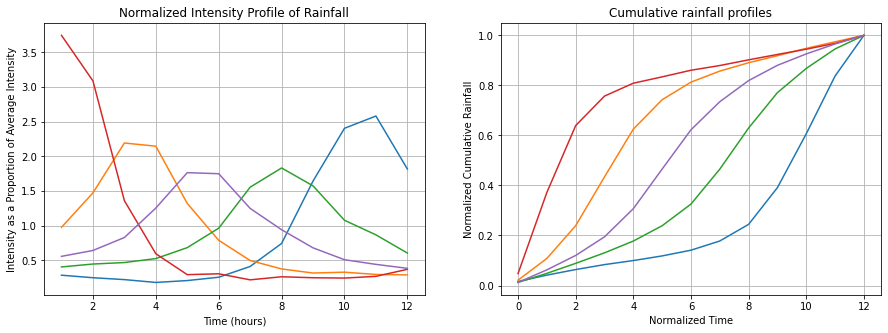

In [157]:
fig, ax=plt.subplots(ncols=2, figsize=(15, 5))
for centroid_cumulative in centroids:
    # Find the times in hours
    time_hours = np.array(range(0,len(centroid_cumulative)))  # Time in hours

    # Convert cumulative to intensity (mm/hour)
    intensity = np.diff(centroid_cumulative) / np.diff(time_hours)

    # Calculate average intensity
    average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

    # Normalize intensity by average intensity
    normalized_intensity = intensity / average_intensity

    start_index, end_index = find_heaviest_rainfall_window(normalized_intensity)
    # print("Heaviest rainfall from index:", start_index, "to", end_index)
        
    # Plotting the normalized intensity profile
    ax[0].plot(time_hours[1:], normalized_intensity)
    ax[0].set_title('Normalized Intensity Profile of Rainfall')
    ax[0].set_xlabel('Time (hours)')
    ax[0].set_ylabel('Intensity as a Proportion of Average Intensity')
    ax[0].grid(True)
    
    #
    ax[1].plot(centroid_cumulative, label=f'Cluster ')
    ax[1].set_title('Cumulative rainfall profiles')
    ax[1].set_xlabel('Normalized Time')
    ax[1].set_ylabel('Normalized Cumulative Rainfall')
    ax[1].grid(True)

In [86]:
# df= pd.DataFrame({'cluster_num':labels, 'duration':durations_for_profiles})
# df['duration'] =  pd.to_numeric(df['duration'])
# mean_durations = df.groupby('cluster_num')['duration'].mean()
# mean_durations[0]

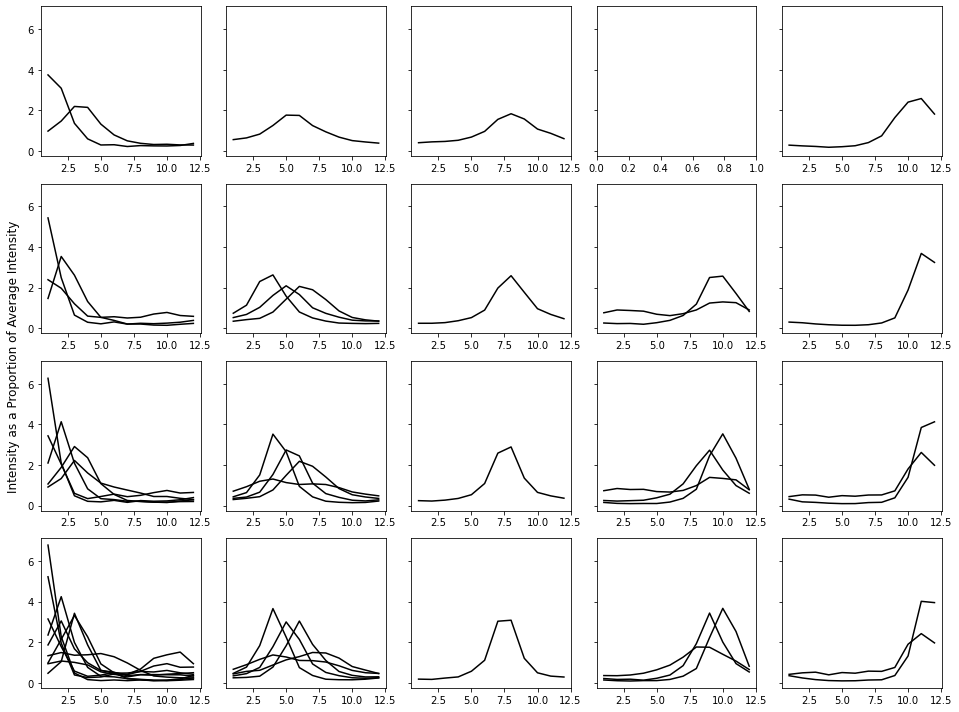

In [164]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13,10), sharey=True)

# Assuming `profiles` is your array where rows are the dimensionless profiles
for num_clusters in [5,10,15,20]:
    # Create and fit the model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(profiles)

    # Get cluster labels for each profile
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    df= pd.DataFrame({'cluster_num':labels, 'duration':durations})
    df['duration'] =  pd.to_numeric(df['duration'])
    df.groupby('cluster_num')['duration'].mean()
    
    for num, centroid_cumulative in enumerate(centroids):

        # Find portion which is heaviest
        heaviest_segment = find_fifth_with_most_rain(centroid_cumulative)

        # Convert to intensity
        time_hours = np.array(range(0,len(centroid_cumulative)))  # Time in hours

        # Convert cumulative to intensity (mm/hour)
        intensity = np.diff(centroid_cumulative) / np.diff(time_hours)

        # Calculate average intensity
        average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

        # Normalize intensity by average intensity
        normalized_intensity = intensity / average_intensity
        
                   
        if num_clusters ==5 :
            axs[0, heaviest_segment-1].plot(time_hours[1:], normalized_intensity,
                                  color='black')
        elif num_clusters ==10:
            axs[1,heaviest_segment-1].plot(time_hours[1:], normalized_intensity,
                                  color='black')
        elif num_clusters ==15:
            axs[2,heaviest_segment-1].plot(time_hours[1:], normalized_intensity,
                                  color='black') 
        else:
            axs[3,heaviest_segment-1].plot(time_hours[1:], normalized_intensity,
                                  color='black')  

    # Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)
plt.show()

In [ ]:
# # Define durations and the measurement interval (in hours)
# durations = [0.5, 1, 2, 3,6,12,24]
# interval = 0.05  # consistent small interval for better simulation

# # Plotting setup
# fig, axs = plt.subplots(4, 2, figsize=(10, 20))
# axs = axs.flatten()
# for yr in range(2001,2019):
#     for i, duration in enumerate(durations):
#         test = pd.read_csv(f"../../ProcessedData/IndependentEvents/{em}/Gauge{gauge_num}/Option1/{duration}hrs_{yr}_v1.csv")
#         times = np.array(range(0,len(test)))
#         amounts = np.array(test['precipitation (mm)'])
#         normalized_time, normalized_rainfall = create_dimensionless_profile(times, amounts)
#         interpolated_rainfall = interpolate_and_bin(normalized_time, normalized_rainfall)

#         axs[i].plot(np.linspace(0, 1, 12), interpolated_rainfall, marker='o', label=f'Duration {duration} hrs')
#         axs[i].set_title(f'Dimensionless Profile for {duration} Hour Duration')
#         axs[i].set_xlabel('Normalized Time (Binned)')
#         axs[i].set_ylabel('Normalized Cumulative Rainfall')
#         axs[i].grid(True)

# plt.tight_layout()
# plt.show()

In [ ]:
# Example of smoothing centroids (using a simple moving average here for demonstration)
def smooth_centroid(centroid, window_size=3):
    return np.convolve(centroid, np.ones(window_size) / window_size, mode='same')

# Assuming `centroids` is an array where each row is a centroid
smoothed_centroids = np.array([smooth_centroid(centroid) for centroid in centroids])

# Plotting the smoothed centroids
plt.figure(figsize=(10, 6))
for i, centroid in enumerate(smoothed_centroids):
    plt.plot(centroid, label=f'Cluster {i+1} Summary Profile')
plt.title('Smoothed Summary Profiles of Dimensionless Rainfall')
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Cumulative Rainfall')
plt.legend()
plt.show()
